## <b> [3단계] AI 모델링
---

## 1, 2 단계에서 진행하신 내용을 아래에 그대로 진행해주세요.

---

# <b>Step 0. 라이브러리 import 및 데이터 불러오기
### **가. 라이브러리 import**

In [ ]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

In [ ]:
import statsmodels.api as sm

def forward_stepwise_logistic(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = sm.Logit(y_train, x_tr).fit(disp = False) # disp = False 실행로그 안보이게 하기!
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

* 데이터 프레임 관련 라이브러리

In [ ]:
#라이브러리 불러오기

### **나.  학습데이터 불러오기**

In [ ]:
path = 'test_dataset_v01.csv'
data = pd.read_csv(path)
data.head()

,Unnamed: 0,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_hostname_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,...,html_num_tags('iframe'),html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a'),html_num_tags('applet')
0,0,97,0,80.0,17.0,17.0,4,0,0,0,...,0,5.0,0,0,12,1,1,1.0,3.0,0
1,1,37,0,22.0,15.0,15.0,3,1,0,0,...,1,NaN,0,0,158,1,1,NaN,NaN,0
2,2,44,0,NaN,20.0,20.0,3,3,0,0,...,0,6.0,3,3,34,1,1,0.0,136.0,0
3,3,40,0,14.0,26.0,26.0,2,0,0,0,...,0,NaN,0,0,29,1,1,1.0,2.0,0
4,4,43,2,NaN,26.0,26.0,2,0,0,0,...,0,NaN,0,0,41,1,1,NaN,NaN,0


In [ ]:
data.shape

(2441, 24)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2441 entries, 0 to 2440
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               2441 non-null   int64  
 1   url_len                  2441 non-null   int64  
 2   url_num_hyphens_dom      2441 non-null   int64  
 3   url_path_len             1975 non-null   float64
 4   url_domain_len           1975 non-null   float64
 5   url_hostname_len         1978 non-null   float64
 6   url_num_dots             2441 non-null   int64  
 7   url_num_underscores      2441 non-null   int64  
 8   url_query_len            2441 non-null   int64  
 9   url_num_query_para       2441 non-null   int64  
 10  url_ip_present           2441 non-null   int64  
 11  url_entropy              2441 non-null   float64
 12  url_chinese_present      2441 non-null   int64  
 13  url_port                 2441 non-null   int64  
 14  html_num_tags('iframe') 

### **다.  데이터 전처리**

In [ ]:
data.columns

Index(['Unnamed: 0', 'url_len', 'url_num_hyphens_dom', 'url_path_len',
       'url_domain_len', 'url_hostname_len', 'url_num_dots',
       'url_num_underscores', 'url_query_len', 'url_num_query_para',
       'url_ip_present', 'url_entropy', 'url_port', 'html_num_tags('script')',
       'html_num_tags('embed')', 'html_num_tags('object')',
       'html_num_tags('div')', 'html_num_tags('head')',
       'html_num_tags('body')', 'html_num_tags('form')', 'html_num_tags('a')',
       'Result_v1'],
      dtype='object')

In [ ]:
data = data.drop(['Unnamed: 0'], axis = 1)

In [ ]:
#모델링제출용
data = data.drop(['Unnamed: 0', 'url_chinese_present', "html_num_tags('applet')", "html_num_tags('iframe')"], axis = 1)

In [ ]:
data.head(1)

,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_hostname_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,url_ip_present,url_entropy,url_port,html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a')
0,97,0,80.0,17.0,17.0,4,0,0,0,0,4.844913,0,5.0,0,0,12,1,1,1.0,3.0


In [ ]:
data.drop(['Unnamed: 0',"html_num_tags('body')","url_ip_present","url_hostname_len"],axis = 1, inplace = True)

In [ ]:
data.drop(['url_num_hyphens_dom',"html_num_tags('embed')",'url_num_dots','url_domain_len',"'url_num_underscores'",'url_num_query_para','url_port',"html_num_tags('form')","'html_num_tags('embed')'"],axis = 1, inplace = True)

In [ ]:
data.shape

(2441, 20)

In [ ]:
data.columns

Index(['url_len', 'url_num_hyphens_dom', 'url_path_len', 'url_domain_len',
       'url_hostname_len', 'url_num_dots', 'url_num_underscores',
       'url_query_len', 'url_num_query_para', 'url_ip_present', 'url_entropy',
       'url_port', 'html_num_tags('script')', 'html_num_tags('embed')',
       'html_num_tags('object')', 'html_num_tags('div')',
       'html_num_tags('head')', 'html_num_tags('body')',
       'html_num_tags('form')', 'html_num_tags('a')'],
      dtype='object')

In [ ]:
data.columns

Index(['url_len', 'url_num_hyphens_dom', 'url_path_len', 'url_domain_len',
       'url_hostname_len', 'url_num_dots', 'url_num_underscores',
       'url_query_len', 'url_num_query_para', 'url_ip_present', 'url_entropy',
       'url_port', 'html_num_tags('script')', 'html_num_tags('embed')',
       'html_num_tags('object')', 'html_num_tags('div')',
       'html_num_tags('head')', 'html_num_tags('body')',
       'html_num_tags('form')', 'html_num_tags('a')', 'Result_v1'],
      dtype='object')

In [ ]:
data.shape

(2514, 21)

In [ ]:
data.head(5)

,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_hostname_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,url_ip_present,...,url_port,html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a'),Result_v1
0,23.0,0.0,8.0,15.0,15.0,2.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1
1,27.0,0.0,13.0,14.0,14.0,3.0,0.0,0.0,0.0,0.0,...,0.0,15.0,0.0,0.0,151.0,1.0,1.0,1.0,55.0,1
2,39.0,2.0,12.0,27.0,27.0,2.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,332.0,1.0,1.0,0.0,321.0,1
3,18.0,0.0,0.0,18.0,18.0,2.0,0.0,0.0,0.0,0.0,...,0.0,4.0,1.0,1.0,3.0,1.0,1.0,0.0,18.0,1
4,49.0,0.0,30.0,19.0,19.0,4.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,19.0,1.0,1.0,1.0,4.0,-1


In [ ]:
data.to_csv("modelingfile.csv", mode='w')

In [ ]:
data.shape

(2441, 20)

# 결측치 처리

In [ ]:
data.isna().sum()

url_len                      0
url_num_hyphens_dom          0
url_path_len               466
url_domain_len             466
url_hostname_len           463
url_num_dots                 0
url_num_underscores          0
url_query_len                0
url_num_query_para           0
url_ip_present               0
url_entropy                  0
url_port                     0
html_num_tags('script')    467
html_num_tags('embed')       0
html_num_tags('object')      0
html_num_tags('div')         0
html_num_tags('head')        0
html_num_tags('body')        0
html_num_tags('form')      467
html_num_tags('a')         461
dtype: int64

In [ ]:
data = data.fillna(data.mean())

In [ ]:
data.isna().sum()

url_len                    0
url_num_hyphens_dom        0
url_path_len               0
url_domain_len             0
url_hostname_len           0
url_num_dots               0
url_num_underscores        0
url_query_len              0
url_num_query_para         0
url_ip_present             0
url_entropy                0
url_port                   0
html_num_tags('script')    0
html_num_tags('embed')     0
html_num_tags('object')    0
html_num_tags('div')       0
html_num_tags('head')      0
html_num_tags('body')      0
html_num_tags('form')      0
html_num_tags('a')         0
dtype: int64

In [ ]:
# best 모델로 예측 및 평가
#p1 = m_gs1.predict(data)
#p2 = m_gs1.predict(data)
#p3= m_gs1.predict(data)
p4 =m_gs1.predict(data)

### **라. train_test_split을 이용하여 train/test  데이터 분리**



In [ ]:
target = 'Result_v1'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [ ]:
# train_test_split 사용
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 2022)

In [ ]:
x_train.shape

(1759, 20)

In [ ]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### **마. Confusion Matrix 함수 정의**


#### Confusion Matrix란 Training 을 통한 Prediction 성능을 측정하기 위해 예측 value와 실제 value를 비교하기 위한 표입니다.
#### 아래 함수는 이번 과제에서 confusion matrix 결과를 보기 쉽게 표현한 것으로 사용 예를 참고하여 모델 결과 확인에 사용하시기 바랍니다.



**<span style="color:green">[참고링크] 공식 Document**</span>
 
* confusion matrix(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [ ]:
from sklearn.metrics import classification_report as creport
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
def plot_confusion_matrix(ax, matrix, labels = ['malicious','benign'], title='Confusion matrix', fontsize=9):
    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='90', fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Blues)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()

### <span style="color:blue">[예시] Confusion Matrix 사용 방법<span>

- 샘플
#### > confusion = confusion_matrix(test_y, dt_pred)
#### > fig, ax = plt.subplots(figsize=(10,3))
#### > plot_confusion_matrix(ax, confusion, fontsize=30)


---

## <b> Q. AI 분류 모델 만들기

* 전처리한 데이터셋을 활용해 악성사이트 여부를 판별하는 AI 분류 모델을 <font color="red">최소 3개 이상 </font>만들어보세요.

In [ ]:
# 1. import
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC

In [ ]:
x_train.shape

(1759, 20)

In [ ]:
x_train.columns

Index(['url_len', 'url_num_hyphens_dom', 'url_path_len', 'url_domain_len',
       'url_hostname_len', 'url_num_dots', 'url_num_underscores',
       'url_query_len', 'url_num_query_para', 'url_ip_present', 'url_entropy',
       'url_port', 'html_num_tags('script')', 'html_num_tags('embed')',
       'html_num_tags('object')', 'html_num_tags('div')',
       'html_num_tags('head')', 'html_num_tags('body')',
       'html_num_tags('form')', 'html_num_tags('a')'],
      dtype='object')

In [ ]:
# 2.선언 

model = SVC()


In [ ]:
# 3. fit(), 학습
model.fit(x_train, y_train)


SVC()

In [ ]:
# 4. predict(), 예측

pred = model.predict(x_val)



In [ ]:
# train 및 val 데이터 정확도 확인 
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[255 114]
 [ 29 357]]
              precision    recall  f1-score   support

          -1       0.90      0.69      0.78       369
           1       0.76      0.92      0.83       386

    accuracy                           0.81       755
   macro avg       0.83      0.81      0.81       755
weighted avg       0.83      0.81      0.81       755



In [ ]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

# DT

In [ ]:
# dictionary형태로 선언
params = { 'max_depth' : range(2,11), 'min_samples_leaf':range(10,101,10)}
params

{'max_depth': range(2, 11), 'min_samples_leaf': range(10, 101, 10)}

In [ ]:
# 기본모델
m = DecisionTreeClassifier()

# Random Search 설정.
m3 = GridSearchCV(m, params, cv = 5)

In [ ]:
# 학습 
m3.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 11),
                         'min_samples_leaf': range(10, 101, 10)})

In [ ]:
# 최적의 파라미터
m3.best_params_

{'max_depth': 5, 'min_samples_leaf': 10}

In [ ]:
# best 모델로 예측 및 평가
p3 = m3.predict(x_val)
print(classification_report(y_val, p3))

              precision    recall  f1-score   support

          -1       0.94      0.90      0.92       369
           1       0.91      0.94      0.92       386

    accuracy                           0.92       755
   macro avg       0.92      0.92      0.92       755
weighted avg       0.92      0.92      0.92       755



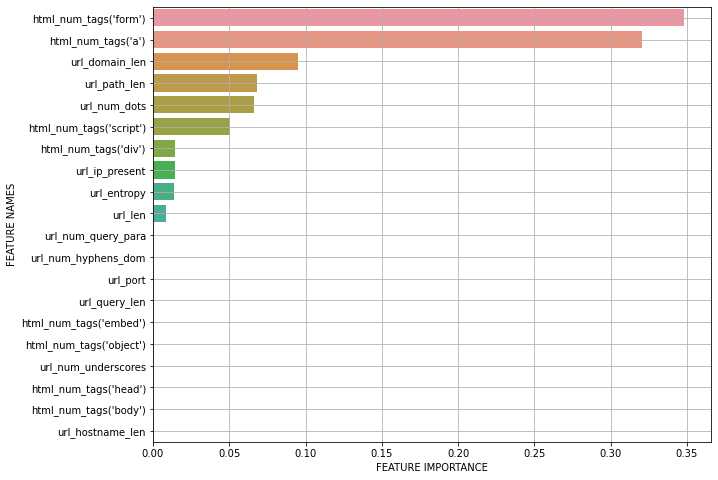

In [ ]:
# 이 이름을 이용하여 변수중요도 뽑기
result = plot_feature_importance(m3.best_estimator_.feature_importances_, list(x_train))

# SVM

In [ ]:
params = { 'C' : np.linspace(0.1, 5, 10), 'gamma' : np.linspace(0.1, 5, 10) }
params

{'C': array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
        2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ]),
 'gamma': array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
        2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ])}

In [ ]:
# 기본모델
m = SVC()

# Random Search 설정.
m5 = GridSearchCV(m, params, cv=5)

In [ ]:
# 학습 : model이 아니라 model_rs
m5.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
       2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ]),
                         'gamma': array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
       2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ])})

In [ ]:

m5.best_params_

{'C': 5.0, 'gamma': 3.911111111111112}

In [ ]:
# best 모델로 예측 및 평가
p5 = m5.predict(x_val_s)
print(classification_report(y_val, p5))

              precision    recall  f1-score   support

          -1       0.89      0.90      0.90       369
           1       0.90      0.90      0.90       386

    accuracy                           0.90       755
   macro avg       0.90      0.90      0.90       755
weighted avg       0.90      0.90      0.90       755



# 랜덤포레스트

In [ ]:
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import * 

In [ ]:
params = {'n_estimators':range(5,101,5), 'max_features':range(1,5)}

In [ ]:
m = RandomForestClassifier()
m_gs1 = GridSearchCV(m, params, cv = 5, verbose = 3)

In [ ]:
m_gs1.fit(x_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 2/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 3/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 4/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 5/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 1/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 2/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 3/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 4/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 5/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 1/5] END ................max_features=1, n_estimators=15; total time=   0.0s
[CV 2/5] END ................max_features=1, n_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 5),
                         'n_estimators': range(5, 101, 5)},
             verbose=3)

In [ ]:
m_gs1.best_params_, m_gs1.best_score_

({'max_features': 3, 'n_estimators': 65}, 0.9505309505309505)

In [ ]:
p1 = m_gs1.predict(x_val)
print(classification_report(y_val, p1))

              precision    recall  f1-score   support

          -1       0.97      0.96      0.97       369
           1       0.96      0.97      0.97       386

    accuracy                           0.97       755
   macro avg       0.97      0.97      0.97       755
weighted avg       0.97      0.97      0.97       755



# XGB

In [ ]:
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
params = { 'max_depth':[3,5,8], 'n_estimators':[50,100,150], 'learning_rate':[0.01,0.1,0.2]}

In [ ]:
m = XGBClassifier()
m_gs = GridSearchCV(m, params, cv = 5, verbose = 3)

In [ ]:
m_gs.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.0s
[CV 2/5] END learning_rate=0.0

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [-1  1]

In [ ]:
m_gs.best_params_

In [ ]:
m_gs.best_score_

In [ ]:
pred = m_gs.predict(x_val)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

In [ ]:
r = plot_feature_importance(m_gs.best_estimator_.feature_importances_, list(x_train))

In [ ]:
expected = pd.Series(p1)
expected

0       1
1       1
2       1
3      -1
4      -1
       ..
2436    1
2437   -1
2438    1
2439   -1
2440    1
Length: 2441, dtype: int64

In [ ]:
expected.shape

(2441,)

In [ ]:
id_ = pd.Series(list(range(0,2441)))
id_

0          0
1          1
2          2
3          3
4          4
        ... 
2436    2436
2437    2437
2438    2438
2439    2439
2440    2440
Length: 2441, dtype: int64

In [ ]:
pd.DataFrame(id_)

,0
0,0
1,1
2,2
3,3
4,4
...,...
2436,2436
2437,2437
2438,2438
2439,2439


In [ ]:
pd.DataFrame(expected)

,0
0,1
1,1
2,1
3,-1
4,-1
...,...
2436,1
2437,-1
2438,1
2439,-1


In [ ]:
test_modeling=pd.concat([id_,expected])

In [ ]:
expected = list(expected)

In [ ]:
id_ = list(range(0,2441))


In [ ]:
df2 = pd.DataFrame({
    'id':id_,
    'expected':expected
}, columns=['id','expected'])
df2

,id,expected
0,0,1
1,1,1
2,2,1
3,3,-1
4,4,-1
...,...,...
2436,2436,1
2437,2437,-1
2438,2438,1
2439,2439,-1


In [ ]:
df2.to_csv("modeling_test.csv", mode="w", index=False)

In [ ]:
expected2 = pd.Series(p2)

In [ ]:
df3 = pd.DataFrame({
    'id':id_,
    'expected':expected2
}, columns=['id','expected'])
df3

,id,expected
0,0,1
1,1,1
2,2,1
3,3,-1
4,4,1
...,...,...
2436,2436,1
2437,2437,-1
2438,2438,1
2439,2439,-1


In [ ]:
df3.to_csv("modeling_test2.csv", mode="w", index=False)

In [ ]:
expected3 = pd.Series(p3)

In [ ]:
df4 = pd.DataFrame({
    'id':id_,
    'expected':expected3
}, columns=['id','expected'])
df4

,id,expected
0,0,1
1,1,1
2,2,1
3,3,-1
4,4,-1
...,...,...
2436,2436,1
2437,2437,1
2438,2438,1
2439,2439,-1


In [ ]:
df4.to_csv("modeling_test3.csv", mode="w", index=False)

In [ ]:
expected4 = pd.Series(p4)

In [ ]:
df5 = pd.DataFrame({
    'id':id_,
    'expected':expected4
}, columns=['id','expected'])
df5

,id,expected
0,0,-1
1,1,1
2,2,1
3,3,-1
4,4,1
...,...,...
2436,2436,1
2437,2437,1
2438,2438,1
2439,2439,-1


In [ ]:
df5.to_csv("modeling_test4.csv", mode="w", index=False)